# TODO!!!!
- Try: Use the custom non-neg min_max_norm thing
- Try: Use the custom NonNegMinMaxNorm thing with the L1 norm

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from numpy.lib.stride_tricks import sliding_window_view

In [2]:
# import wandb
# wandb.init(project='radar-rainfall-runoff', entity='sverrirhd')


In [3]:

# load data
# df_map = pd.read_pickle('./60times10_CAPPI_raw').resample('1h').sum()
# df_map = pd.read_pickle('./8times12_CAPPI_raw').resample('1h').sum()
# H,W = 8,12
df_map = pd.read_pickle('./14times18_CAPPI_raw').resample('1h').sum()
H,W = 14,18
# df_map = pd.read_pickle('./18times22_CAPPI_raw').resample('1h').sum()
# H,W = 18,22
# df_map = pd.read_pickle('./40times60_CAPPI_raw').resample('1h').sum()
# H,W = 40,60
df_inputs = pd.read_pickle('./2020_input_data_four_areas')
# df_target = pd.read_pickle('../Drainage data/drainage_ANA_target')
# df_target_2 = pd.read_pickle('../Drainage data/drainage_ING_target')
df_target = pd.read_pickle('../Drainage data/all_drainage_data_uncorrected.pkl')
# Reshape/select data of interest
df_temp = df_inputs.iloc[:,[0]]


# Remove/reduce effect of cycle
cycle_length = 24
remove_cycle = lambda x,c : (np.nanmax([x[c],0]) + (x.diff(c).cumsum()/c).shift(-c))
remove_season = lambda x : x - x.rolling(24*7*2,min_periods = 0).min()

# for col in df_target:
#     df_target.loc[:,col] = remove_cycle(df_target.loc[:,col],cycle_length)
#     df_target.loc[:,col] = remove_season(df_target.loc[:,col])

# inputs = df_temp.dropna().iloc[1800:]
inputs = df_inputs.loc[:,['temperature','radiation','moist_pressure']]#.iloc[1800:]
target = df_target#.iloc[1800:]
# target_2 = df_target_2.dropna().iloc[1800:]

# H,W = 40,60
C = inputs.shape[-1]

dt_start = datetime.datetime(2020,1,1,0,0,0)
dt_end = datetime.datetime(2020,12,31,23,59,59)
new_index = pd.date_range(dt_start,dt_end, freq='1h')

inputs = inputs.resample('1h').sum().reindex(new_index)
df_map = df_map.resample('1h').sum().reindex(new_index)

df_target = df_target.resample('1h').mean().reindex(new_index)
df_target = df_target.drop('MOS-HOL',axis='columns').interpolate(method='linear')
# # target_2 = target_2.loc[common_index].resample('1h').interpolate(method='linear')

inputs = inputs.values
input_2d = df_map.values.reshape(-1,H,W) 
target = df_target.values
# # target = np.c_[target.values,target_2.values]
# target

In [34]:
# input_2d.shape

(3000.0, 3400.0)

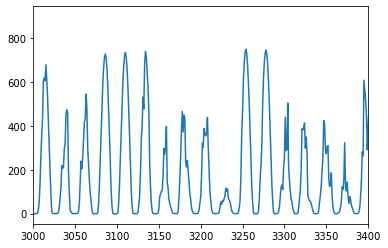

In [4]:
plt.plot(df_inputs.loc[:,'radiation'].values)
plt.xlim(3000,3400)

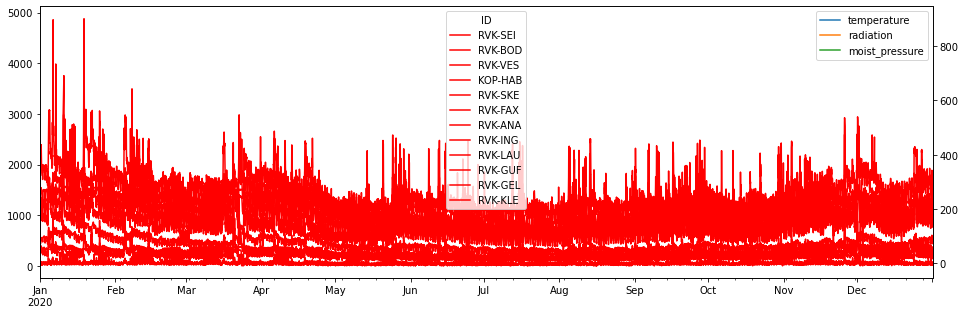

In [5]:

plt.figure(figsize=(16,5))
df_target.plot(color='red',ax=plt.gca())
plt.twinx().plot(inputs)
plt.legend(['temperature','radiation','moist_pressure'])
plt.show()


In [6]:
# correlations = np.corrcoef(input_2d.reshape(-1,40*60),target.reshape(-1,12),rowvar=False, )

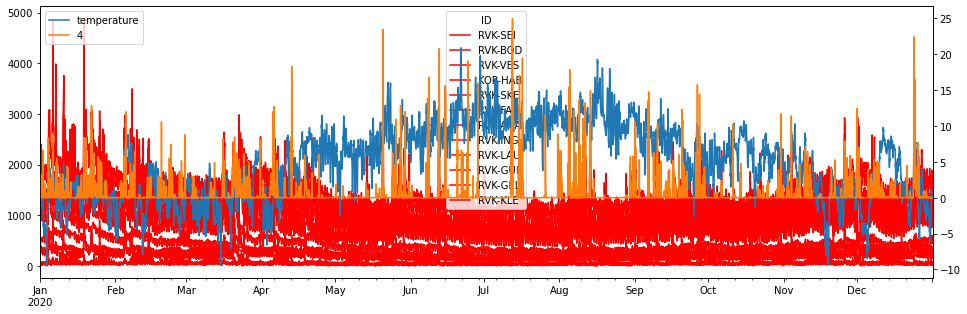

In [7]:
plt.figure(figsize=(16,5))
df_target.plot(color='red',ax=plt.gca())
df_inputs.iloc[:,[0,-1]].plot(ax = plt.twinx())
plt.legend()
plt.show()

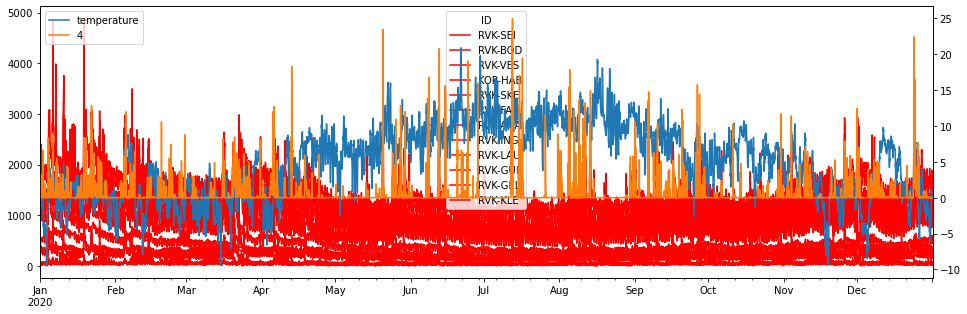

(439888.0, 440688.0)

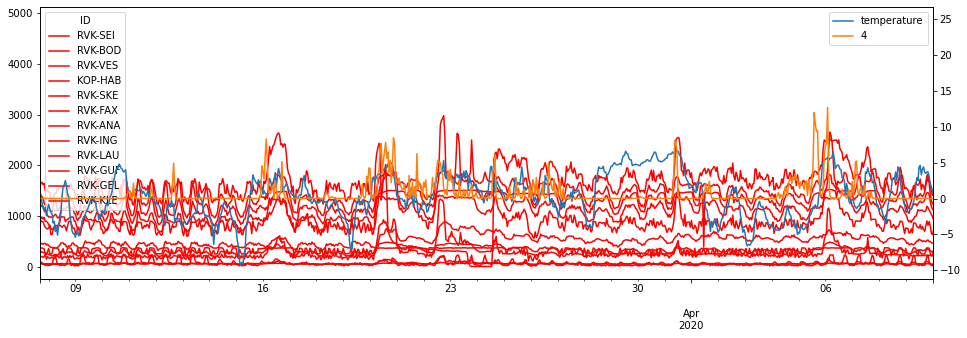

In [8]:
plt.figure(figsize=(16,5))
df_target.plot(color='red',ax=plt.gca())
df_inputs.iloc[:,[0,-1]].plot(ax = plt.twinx())
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
df_target.plot(color='red',ax=plt.gca())
df_inputs.iloc[:,[0,-1]].plot(ax = plt.twinx())
plt.legend()
plt.xlim(df_inputs.index[1600],df_inputs.index[2400])

NameError: name 'radar' is not defined

In [9]:
class MinMaxConstraint(tf.keras.constraints.Constraint):
    """constrain model weights between [x_min, x_max]."""
    def __init__(self, x_min=0.0, x_max=1.0):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        # TODO: add sanity check if x_max == x_min or w_max == w_min
    
    def __call__(self, w):
        is_geq = tf.cast(tf.greater_equal(w, self.x_min), tf.keras.backend.floatx())
        is_leq = tf.cast(tf.less_equal(w, self.x_max), tf.keras.backend.floatx())
        nis_geq = -1*(is_geq-1)
        nis_leq = -1*(is_leq-1)
        
        # only keep if it's bigger than min
        w = w * is_geq
        # set the ones not bigger than min to the min
        w = w + nis_geq * self.x_min
        # only keep if it's smaller than max
        w = w * is_leq
        # turn the ones not smaller to the min
        w = w + nis_leq * self.x_max
        return w
test_data = tf.reshape(tf.range(-5,5,dtype='float32')/2,(2,5), )
# print(test_data)
MinMaxConstraint(0.,1.)(test_data)
# print()

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 1. , 1. , 1. ]], dtype=float32)>

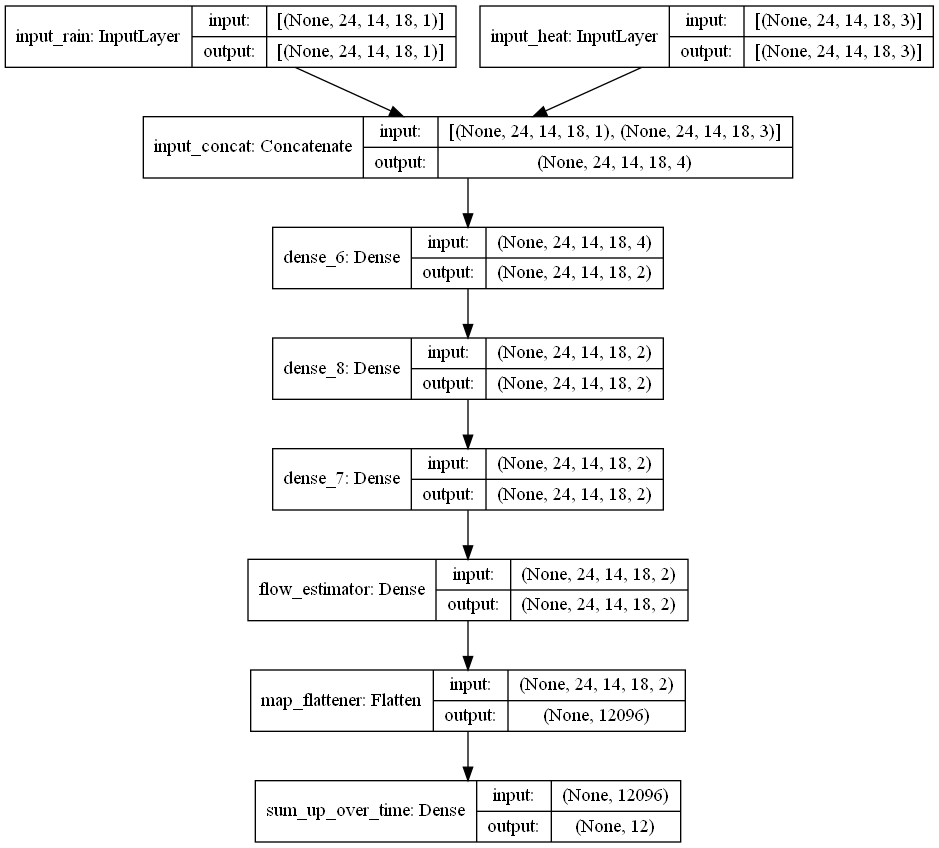

In [27]:
# Settings
sequence_size = 24
n_hidden = 10
n_outputs = target.shape[-1]
input_shape_1 = (sequence_size,H,W,1)
# S,H,W,C = input_shape_1

# Learning layers

# conv_lstm = tf.keras.layers.ConvLSTM2D(filters = n_hidden,
#                                        kernel_size = 1,
#                                        strides = 1,
#                                       #  activation='relu', # only positive flow (Fron n_hidden sources)
#                                       #  use_bias = False, # No default flow? (Already removed from time series)
#                                        padding='valid',
#                                        data_format = 'channels_last',
#                                        return_sequences = True,
#                                        name = 'ConvLSTM2'
#                                        )

conv_lstm = tf.keras.layers.Dense(2, activation = 'relu')

dense_point_flow = tf.keras.layers.Dense(2,
                                         activation='relu',
                                         name = 'flow_estimator',
                                        #  kernel_initializer = tf.keras.initializers.random_uniform(0.0001,0.1),
                                        #  bias_initializer = tf.keras.initializers.random_uniform(0.0001,0.1),
                                         )

dense_spatio_temporal_sum = tf.keras.layers.Dense(n_outputs,
                                                  activation = 'relu',
                                                  name = 'sum_up_over_time',
                                                  # use_bias = True,
                                                  kernel_regularizer = tf.keras.regularizers.L2(100),
                                                  # Add upp the flow from different locations at different times (only positive flow)
                                                  # We technically know that the combined weight for both squares should never be more than 1
                                                  # I.e. min_max_norms along the (2) n_outputs dimension
                                                  # kernel_constraint = MinMaxConstraint(0.000001,1.),
                                                  # kernel_initializer = tf.keras.initializers.random_uniform(0.0001,0.1),
                                                  # bias_initializer = tf.keras.initializers.random_uniform(0.0001,0.1),
                                                #   kernel_constraint = tf.keras.constraints.MinMaxNorm(0.00001,1.0, rate = 0.99, axis = 1),
                                                  kernel_constraint = tf.keras.constraints.NonNeg()
                                                  ) 



# Reshaping layers
input_concat = tf.keras.layers.Concatenate(-1, name = 'input_concat')
lstm_output_concat = tf.keras.layers.Concatenate(-1, name = 'lstm_output_concat')
map_flatten = tf.keras.layers.Flatten(name = 'map_flattener')


# Model construction
input_rain = tf.keras.layers.Input(input_shape_1, name = 'input_rain')
input_other = tf.keras.layers.Input(input_shape_1[:-1] + (inputs.shape[-1],), name = 'input_heat')
input_combined = input_concat([input_rain,input_other])

# lstm_output = conv_lstm(input_combined)
lstm_output = tf.keras.layers.Dense(2, activation = 'relu')(tf.keras.layers.Dense(2, activation = 'relu')(conv_lstm(input_combined)))

flow_time_series = dense_point_flow(lstm_output) # gather flow from all sources
flat_timeseries = map_flatten(flow_time_series)

drainage = dense_spatio_temporal_sum(flat_timeseries) # Heavily constrained adding up of all flows going into each catchment

model = tf.keras.Model([input_rain,input_other], drainage)
# Model visualization
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [28]:
output_sequences = sliding_window_view(target,(sequence_size,n_outputs)).squeeze()[:,-1]
rainfall_input_sequences = sliding_window_view(input_2d,(sequence_size,input_2d.shape[1],input_2d.shape[2])).reshape((-1,sequence_size,H,W,1))

temperature_map_placeholder = np.full((len(inputs),H,W,C),inputs[:,np.newaxis,np.newaxis])
temperature_input_sequences = sliding_window_view(temperature_map_placeholder,(sequence_size,H,W,C)).reshape((-1,sequence_size,H,W,C))

# optimizer = tf.optimizers.Adam(learning_rate=1e-3, clipnorm = 0.01)
optimizer = tf.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer,
              # loss=tf.losses.MeanSquaredLogarithmicError(),
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tfp.stats.correlation,tf.losses.MSE])

val_ratio = 0.2
batch_size = 16
with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit([rainfall_input_sequences,temperature_input_sequences], output_sequences,
            validation_split = val_ratio,
            batch_size = batch_size,
            epochs = 50,
            verbose = 1,
            shuffle=True,
            )

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [22]:
output_sequences = sliding_window_view(target,(sequence_size,n_outputs)).squeeze()[:,-1]
rainfall_input_sequences = sliding_window_view(input_2d,(sequence_size,input_2d.shape[1],input_2d.shape[2])).reshape((-1,sequence_size,H,W,1))

temperature_map_placeholder = np.full((len(inputs),H,W,C),inputs[:,np.newaxis,np.newaxis])
temperature_input_sequences = sliding_window_view(temperature_map_placeholder,(sequence_size,H,W,C)).reshape((-1,sequence_size,H,W,C))

optimizer = tf.optimizers.Adam(learning_rate=1e-6) #, clipnorm = 0.01)
model.compile(optimizer=optimizer,
              # loss=tf.losses.MeanSquaredLogarithmicError(),
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tfp.stats.correlation,tf.losses.MSE])

val_ratio = 0.2
batch_size = 8
with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit([rainfall_input_sequences,temperature_input_sequences], output_sequences,
            validation_split = val_ratio,
            batch_size = batch_size,
            epochs = 50,
            verbose = 1,
            shuffle=True,
            )

Epoch 1/50
876/876 [==============================] - 3s 3ms/step - loss: 36083.8242 - mean_absolute_error: 99.3517 - correlation: 0.5787 - mean_squared_error: 31230.4102 - val_loss: 37558.7773 - val_mean_absolute_error: 110.3646 - val_correlation: -0.0189 - val_mean_squared_error: 32688.6504
Epoch 2/50
876/876 [==============================] - 3s 3ms/step - loss: 35551.0898 - mean_absolute_error: 97.6270 - correlation: 0.5707 - mean_squared_error: 30660.7793 - val_loss: 37467.4805 - val_mean_absolute_error: 110.3983 - val_correlation: -0.0180 - val_mean_squared_error: 32562.1152
Epoch 3/50
876/876 [==============================] - 3s 4ms/step - loss: 35244.1641 - mean_absolute_error: 97.0736 - correlation: 0.5717 - mean_squared_error: 30322.7871 - val_loss: 37507.9805 - val_mean_absolute_error: 110.9736 - val_correlation: -0.0168 - val_mean_squared_error: 32571.3320
Epoch 4/50
201/876 [=====>........................] - ETA: 2s - loss: 38051.9062 - mean_absolute_error: 100.4249 - cor

KeyboardInterrupt: 

In [23]:
start,end = 0,-1
pred = model.predict([rainfall_input_sequences[start:end],temperature_input_sequences[start:end]])

print(pred.shape)
print(np.mean(np.abs(pred - output_sequences[start:end])))

for i in range(12):
    name = df_target.columns[i]
    pred_tmp = pred[:,i]
    y_true_tmp = output_sequences[:,i]
    corr = np.corrcoef(pred_tmp,y_true_tmp[:-1],rowvar=False)[0,1]
    MAE = np.mean(np.abs(pred - output_sequences[start:end]))
    print(f'{name}: corr:{np.round(corr,2)}, MAE:{np.round(MAE,2)}, MAE/MEAN:{np.round(MAE/np.mean(y_true_tmp),2)}')

    pred_tmp = pred[-int(len(pred)*0.2):,i]
    y_true_tmp = output_sequences[-int((len(pred))*0.2):,i]
    corr = np.corrcoef(pred_tmp,y_true_tmp,rowvar=False)[0,1]
    MAE = np.mean(np.abs(pred_tmp - y_true_tmp))
    print(f'test:\t corr:{np.round(corr,2)}, MAE:{np.round(MAE,2)}, MAE/MEAN:{np.round(MAE/np.mean(y_true_tmp),2)}')
    


(8760, 12)
99.80552621866768
RVK-SEI: corr:0.62, MAE:99.81, MAE/MEAN:2.09
test:	 corr:0.24, MAE:7.72, MAE/MEAN:0.15
RVK-BOD: corr:0.35, MAE:99.81, MAE/MEAN:1.79
test:	 corr:0.21, MAE:16.93, MAE/MEAN:0.27
RVK-VES: corr:0.16, MAE:99.81, MAE/MEAN:1.84
test:	 corr:-0.12, MAE:37.07, MAE/MEAN:0.6
KOP-HAB: corr:0.59, MAE:99.81, MAE/MEAN:0.39
test:	 corr:0.36, MAE:50.62, MAE/MEAN:0.18
RVK-SKE: corr:0.61, MAE:99.81, MAE/MEAN:0.12
test:	 corr:0.4, MAE:167.8, MAE/MEAN:0.18
RVK-FAX: corr:0.6, MAE:99.81, MAE/MEAN:0.1
test:	 corr:0.38, MAE:210.43, MAE/MEAN:0.2
RVK-ANA: corr:0.57, MAE:99.81, MAE/MEAN:0.08
test:	 corr:0.29, MAE:252.08, MAE/MEAN:0.2
RVK-ING: corr:0.53, MAE:99.81, MAE/MEAN:0.4
test:	 corr:0.31, MAE:58.01, MAE/MEAN:0.2
RVK-LAU: corr:0.52, MAE:99.81, MAE/MEAN:0.13
test:	 corr:0.48, MAE:141.37, MAE/MEAN:0.17
RVK-GUF: corr:0.61, MAE:99.81, MAE/MEAN:0.24
test:	 corr:0.42, MAE:84.88, MAE/MEAN:0.19
RVK-GEL: corr:0.42, MAE:99.81, MAE/MEAN:0.49
test:	 corr:0.33, MAE:53.46, MAE/MEAN:0.25
RVK-KLE:

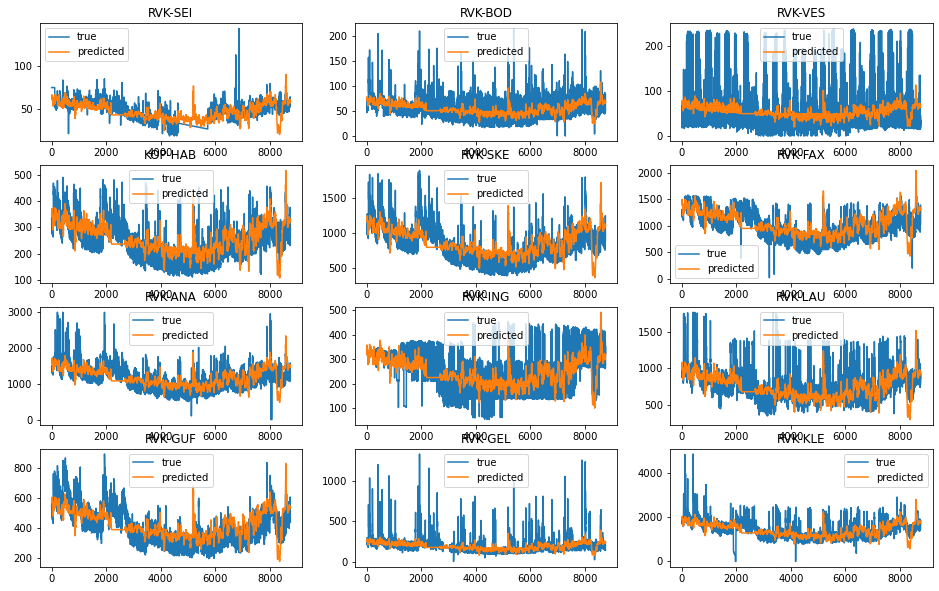

In [24]:

f,axes = plt.subplots(4,3,figsize=(16,10))
for i,ax in enumerate(axes.ravel()):
    ax.plot(output_sequences[start:end,i])
    ax.plot(pred[:,i])
    ax.legend(['true','predicted'])
    ax.set_title(df_target.columns[i])

In [ ]:
# snapshot_string = './TF-convLSTM models/75,8535_12677,5684_124,6675_29054,8711'
# model.save(snapshot_string)

In [ ]:
# model = model.load_weights(snapshot_string)

In [ ]:
[i.name for i in model.weights]

['ConvLSTM2/kernel:0',
 'ConvLSTM2/recurrent_kernel:0',
 'ConvLSTM2/bias:0',
 'flow_estimator/kernel:0',
 'flow_estimator/bias:0',
 'sum_up_over_time/kernel:0',
 'sum_up_over_time/bias:0']

In [ ]:
import imp
imp.reload(fiona)

NameError: name 'fiona' is not defined

In [ ]:
# import fiona
import geopandas as gpd
# 
gpd

AttributeError: partially initialized module 'fiona' has no attribute '_loading' (most likely due to a circular import)

In [ ]:

DIR_map = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Example code/Jonas example of rain data'
DIR_data = 'C:/Users/sverrirhd/vedurgogn/'

bg_map_file = f'{DIR_map}/Iceland_map/geoBoundariesSimplified-3_0_0-ISL-ADM0.shp'
URL_pixel_coords_save = DIR_data + 'radar_pixel_coords.npy'

radar_coords = np.load(URL_pixel_coords_save)
bg_map = gpd.read_file(bg_map_file)

AttributeError: partially initialized module 'fiona' has no attribute '_loading' (most likely due to a circular import)

In [ ]:
weight_maps = model.weights[-2].numpy().reshape(5,H,W,12)

for t in range(5):
    print('t',t)
    f,axes = plt.subplots(4,3,figsize=(4*3,3*4))
    for i,ax in enumerate(axes.ravel()):
        pic = weight_maps[t,:,:,i]
        im = ax.imshow(pic)
        ax.set_title(df_target.columns[i])
        plt.colorbar(im,ax=ax)
    plt.tight_layout()
    plt.savefig(f'./Correlation structure analysis/neural_network_weights/image{t}.png')
    # plt.show()
    plt.close()

t 0
t 1
t 2


OSError: [Errno 22] Invalid argument: './Correlation structure analysis/neural_network_weights/image{t}.png'

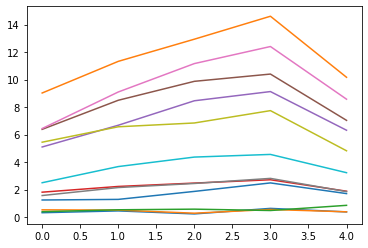

In [ ]:
plt.plot(weight_maps.sum(axis=(1,2)))


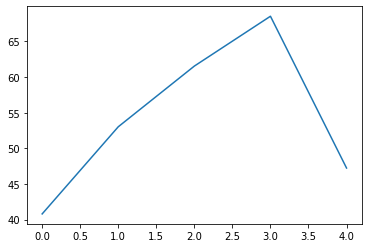

In [ ]:
# plt.plot(maps.sum(axis=(1,2,3)))
# plt.plot(maps.sum(axis=(0,1,2)))
# plt.plot(maps.sum(axis=(0,1,3)))
plt.plot(weight_maps.sum(axis=(1,2,3)))